In [1]:

# Standard library imports
import os
import sys
import logging

# Third-party imports
import pandas as pd
import numpy as np
import cv2

import seaborn as sns
import scipy

import scipy.stats as stats

from matplotlib import pyplot as plt

# Local module imports
sys.path.append(os.path.abspath('..'))
from utils.utils_data import get_veesel_sheets, get_measurements
from utils.utils_constants import (VESSEL_NEPTUNE_PAT_INFO_W_SCORE_PATH as  VESSEL_PAT_INFO_W_SCORE_PATH,
                                   VESSEL_NEPTUNE_PAT_INFO_W_SCORE_W_FEATURE_PATH as  VESSEL_PAT_INFO_W_SCORE_W_FEATURE_PATH,
                                   DISEASE_TYPES, ARTERY_TYPES, CLASSIFICATION_SEVERITY_MAPPING,
                                   MEASUREMENTS_DIR, FEATURES_PATH, CROPPED_VESSELS_DIR)

from utils.utils_vis import gallery_view

# Logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# suffix = "_measurements_lumen_convex"
suffix = "_measurements"

In [3]:
collected_features = pd.read_csv(FEATURES_PATH.replace(".xlsx", f"{suffix}.csv"))
for disease_type in DISEASE_TYPES:
    collected_features[f"{disease_type} Severity"] = collected_features[f"{disease_type} Severity"].map(CLASSIFICATION_SEVERITY_MAPPING)
collected_features = collected_features.dropna()
collected_features.head()

,Slide Name,Image Name,Artery ID,Bounding Box,Artery Type,Arteriosclerosis Severity,Hyalinosis Severity,Artery Area,Log Artery Area,Media Area Ratio,...,Media Variance,Vis Media Peak Indice,Media Peak Height,Media Peak Prominence,Ratio Average,Ratio Median,Ratio Variance,Vis Ratio Peak Indice,Ratio Peak Height,Ratio Peak Prominence
0,10_26609_000_002_L2_TRI,Biopsy_001_WSI_001_A01_87467_29252_539_387.png,A01,"87467, 29252, 539, 387",Interlobular Arteries,0,0,61749.0,11.030833,0.447457,...,0.001232,306.0,0.268764,0.101510,0.244531,0.233086,0.003766,232.0,0.397297,0.397297
1,10_26609_000_002_L2_TRI,Biopsy_001_WSI_001_A02_86515_28505_861_584.png,A02,"86515, 28505, 861, 584",Interlobular Arteries,0,0,100195.5,11.514879,0.761891,...,0.003124,226.0,0.372943,0.296969,0.290994,0.301833,0.009101,302.0,0.430258,0.351727
2,10_26609_000_002_L2_TRI,Biopsy_001_WSI_001_A04_83812_19882_846_1293.png,A04,"83812, 19882, 846, 1293",Interlobular Arteries,0,0,282556.5,12.551634,0.561021,...,0.001035,829.0,0.233525,0.174877,0.444989,0.442482,0.019992,598.0,0.715234,0.681892
3,10_26609_000_002_L2_TRI,Biopsy_001_WSI_001_A05_85633_16311_186_182.png,A05,"85633, 16311, 186, 182",Arterioles,0,0,15934.5,9.676242,0.646114,...,0.003271,127.0,0.385167,0.240482,0.303977,0.279259,0.011658,249.0,0.546768,0.317191
4,10_26609_000_002_L2_TRI,Biopsy_001_WSI_001_A06_83026_12349_173_255.png,A06,"83026, 12349, 173, 255",Arterioles,0,0,21118.0,9.957881,0.575528,...,0.002272,111.0,0.326555,0.212760,0.378544,0.380763,0.011444,77.0,0.584382,0.349198


In [4]:
base_feature_names = [
'Media Area Ratio', 'Intima Area Ratio', 'Lumen Area Ratio'
]
measurement_feature_names = [
                 'Intima Average', 'Intima Median', 'Intima Variance', 'Intima Peak Height', 'Intima Peak Prominence', 
                 'Media Average', 'Media Median', 'Media Variance', 'Media Peak Height', 'Media Peak Prominence', 
                 'Ratio Average', 'Ratio Median', 'Ratio Variance', 'Ratio Peak Height', 'Ratio Peak Prominence']

In [5]:
collected_features.columns

Index(['Slide Name', 'Image Name', 'Artery ID', 'Bounding Box', 'Artery Type',
       'Arteriosclerosis Severity', 'Hyalinosis Severity', 'Artery Area',
       'Log Artery Area', 'Media Area Ratio', 'Intima Area Ratio',
       'Lumen Area Ratio', 'Hyalinosis Area Ratio', 'Artery Aspect Ratio',
       'Artery Convexity', 'Intima Aspect Ratio', 'Intima Convexity',
       'Intima Average', 'Intima Median', 'Intima Variance',
       'Vis Intima Peak Indice', 'Intima Peak Height',
       'Intima Peak Prominence', 'Media Average', 'Media Median',
       'Media Variance', 'Vis Media Peak Indice', 'Media Peak Height',
       'Media Peak Prominence', 'Ratio Average', 'Ratio Median',
       'Ratio Variance', 'Vis Ratio Peak Indice', 'Ratio Peak Height',
       'Ratio Peak Prominence'],
      dtype='object')

2024-07-24 19:34:15,172 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,181 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,255 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,265 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-07-24 19:34:15,309 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,316 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,354 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,361 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


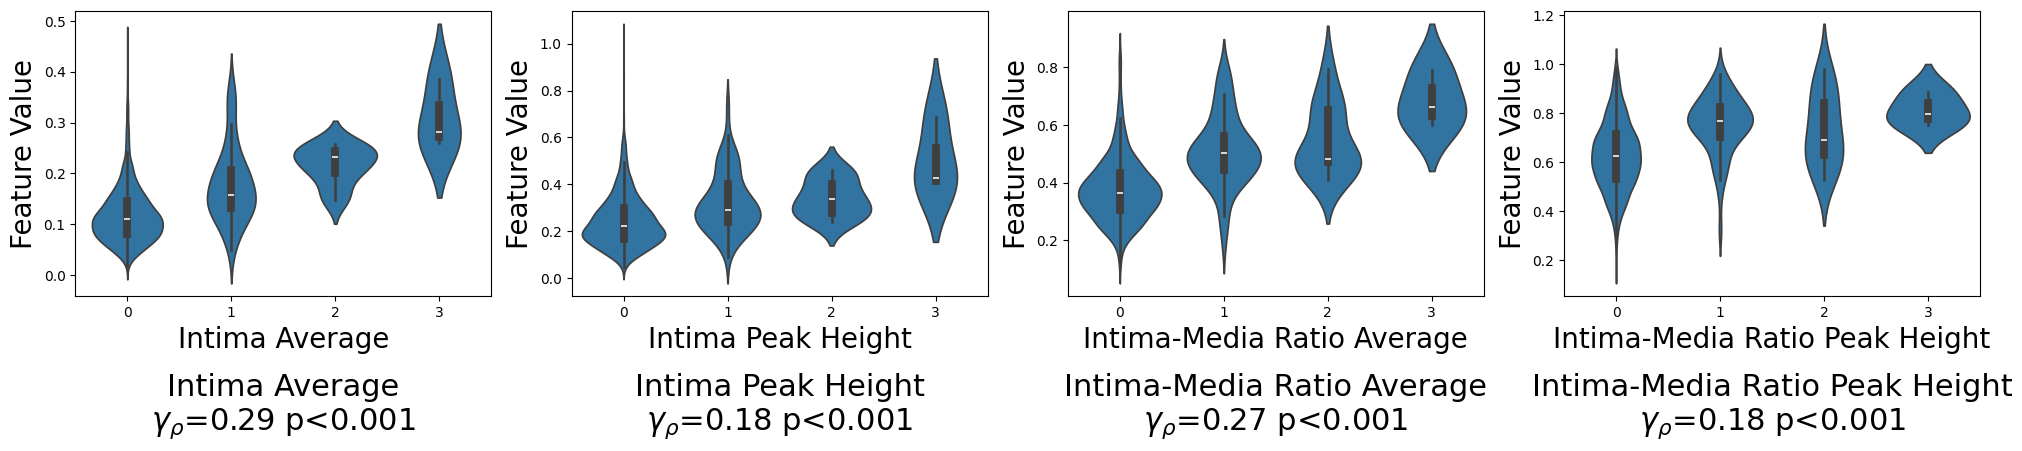

2024-07-24 19:34:15,782 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,789 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,830 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,836 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:15,874 - INFO - Using categorical units to plot a list of strings that are all parsable as 

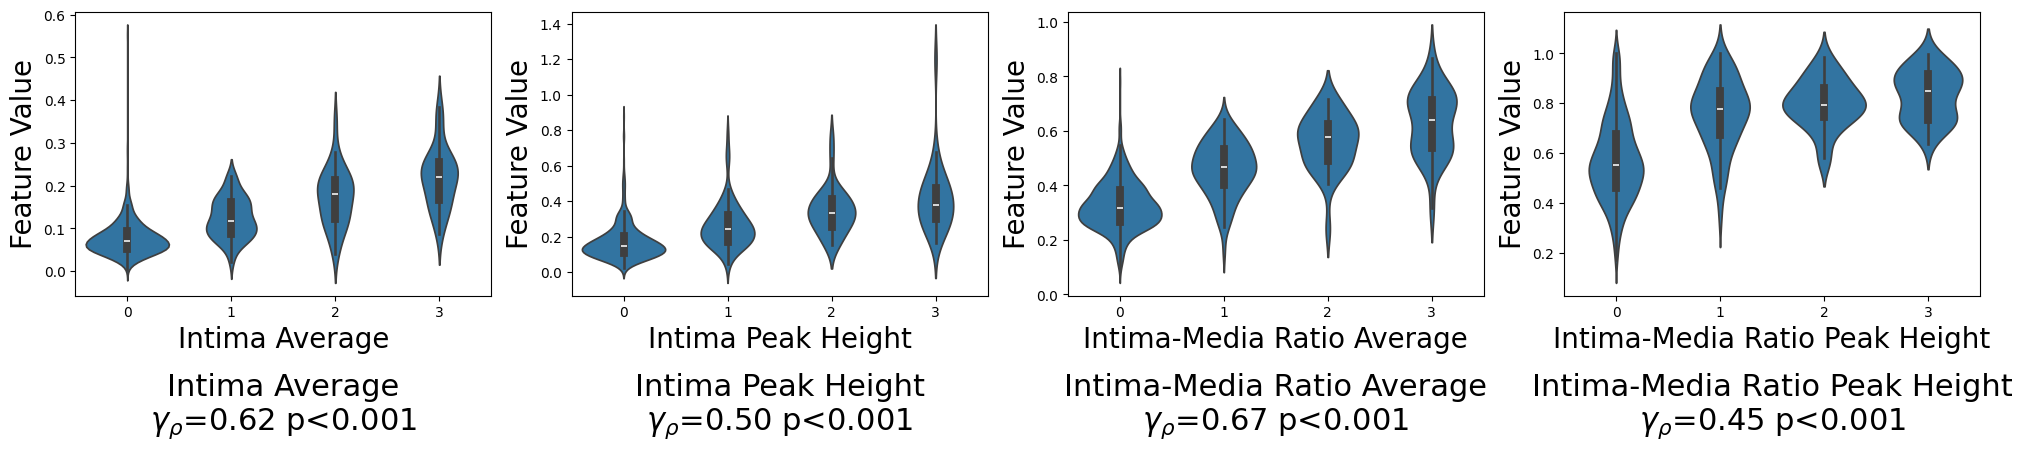

2024-07-24 19:34:16,270 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:16,275 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:16,312 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:16,317 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-24 19:34:16,355 - INFO - Using categorical units to plot a list of strings that are all parsable as 

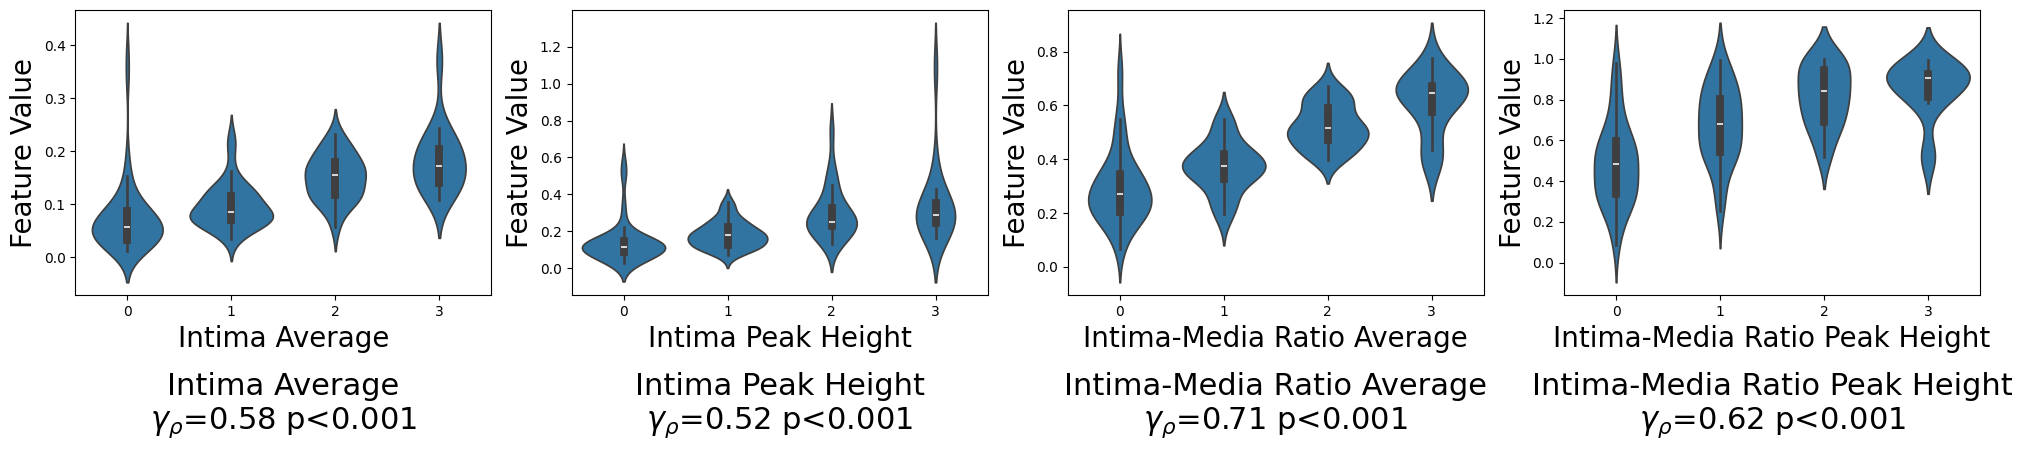

In [6]:
def violin_plots(df, feature_name, severity_type, ax):
    features = df.loc[:, feature_name]
    scores = df.loc[:, f'{severity_type} Severity']
    rho, p_val = scipy.stats.pearsonr(features, scores)
    p_str = f"p<0.001" if p_val < 0.001 else f"p={p_val:.3f}"
    sns.violinplot(x=f'{severity_type} Severity', y=feature_name, data=df, ax=ax)
    if "Ratio" in feature_name: 
        feature_name = feature_name.replace("Ratio", "Intima-Media Ratio")
    ax.set_xlabel(feature_name, fontsize=20)
    ax.set_ylabel("Feature Value", fontsize=20)
    ax.set_title(f"{feature_name}\n$\\gamma_{{\\rho}}$={rho:.2f} {p_str}", y=-0.4, pad=-14, fontsize=22)

feature_names = ['Intima Average', 'Intima Peak Height', 'Ratio Average', 'Ratio Peak Height']
for artery_type in ARTERY_TYPES:
    for disease_type in DISEASE_TYPES:
        if disease_type != "Arteriosclerosis": continue
        fig, axs = plt.subplots(1, len(feature_names), figsize=(5*len(feature_names), 5))  
        for i, feature_name in enumerate(feature_names):
            violin_plots(collected_features.loc[collected_features["Artery Type"]==artery_type, :], 
                         feature_name, disease_type, axs[i])  
        plt.tight_layout()
        plt.show()

In [7]:
pat_df = pd.read_csv(VESSEL_PAT_INFO_W_SCORE_PATH)
feature_path = FEATURES_PATH.replace(".xlsx", f"{suffix}.xlsx")

agg_feature_path = VESSEL_PAT_INFO_W_SCORE_W_FEATURE_PATH.replace(".csv", f"{suffix}.csv")

available_sheetnames = pd.ExcelFile(feature_path, engine='openpyxl').sheet_names
logging.info(f"{len(pat_df)} slides selected, {len(pat_df) - len(available_sheetnames)} discarded, " 
            f"{len(available_sheetnames)} left for analysis.")


for i, (index, row) in enumerate(pat_df.iterrows()):
    slide_filename = row["WSI_Selected"]
    logging.info(f"Processing: {i+1}/{len(pat_df)}: {slide_filename}")
    slide_basename = os.path.splitext(slide_filename)[0]
   
    features = get_veesel_sheets(feature_path, slide_basename, available_sheetnames, remove_others=True)
    if features.empty:
        continue  # Skip to if no relevant data

    measurements_path = os.path.join(MEASUREMENTS_DIR, f"{slide_basename}{suffix}.json")
    measurements = get_measurements(measurements_path, clean=True)

    for disease_type in DISEASE_TYPES:
        features[f"{disease_type} Severity"] = features[f"{disease_type} Severity"].map(CLASSIFICATION_SEVERITY_MAPPING)

    for artery_type in ARTERY_TYPES:
        for feature_name in base_feature_names + measurement_feature_names:
            features_series = features[(features['Artery Type'] == artery_type)][feature_name]
            if not features_series.empty:            
                max_severity = features_series.max()
                mean_severity = features_series.mean()
                median_severity = features_series.median()
                percentile_75th = features_series.quantile(0.75)
                percentile_25th = features_series.quantile(0.25)
            else:
                max_severity = mean_severity = median_severity = percentile_75th = percentile_25th =  None  # or another indicator for no data

            # Storing these values in the DataFrame
            pat_df.loc[index, f'Max_{feature_name}_in_{artery_type}'.replace(" ", "_")] = max_severity
            pat_df.loc[index, f'Mean_{feature_name}_in_{artery_type}'.replace(" ", "_")] = mean_severity
            pat_df.loc[index, f'Median_{feature_name}_in_{artery_type}'.replace(" ", "_")] = median_severity
            pat_df.loc[index, f'75th_{feature_name}_in_{artery_type}'.replace(" ", "_")] = percentile_75th
            pat_df.loc[index, f'25th_{feature_name}_in_{artery_type}'.replace(" ", "_")] = percentile_25th

pat_df.to_csv(agg_feature_path, index=False)

2024-07-24 19:34:17,684 - INFO - 247 slides selected, 15 discarded, 232 left for analysis.
2024-07-24 19:34:17,686 - INFO - Processing: 1/247: 10_26609_000_002_L2_TRI.svs


/tmp/ipykernel_3055367/196994801.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pat_df.loc[index, f'Median_{feature_name}_in_{artery_type}'.replace(" ", "_")] = median_severity
/tmp/ipykernel_3055367/196994801.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pat_df.loc[index, f'75th_{feature_name}_in_{artery_type}'.replace(" ", "_")] = percentile_75th
/tmp/ipykernel_3055367/196994801.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po